### Viz 0: upload and unzip `outputs.tar.gz`

In [1]:
# !tar -xzvf outputs.tar.gz

### Viz 1: import modules

In [1]:
import numpy as np
import pandas as pd 
import datetime
import scipy.stats

### plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rc

# rc('font',**{'family':'serif','serif':['Times']})

# # Remove the font specification
rc('font', family='sans-serif')  # Uses default sans-serif font

# mpl.rcParams.update(mpl.rcParamsDefault)  # Reset to default settings

# rc('text', usetex=True)

#### Setting Up Visualization Parameters

In [2]:
### Set time limit for visualization
t_start = 3600 * 6  # Train service starts at 5:30 am
t_end = 3600 * 10 + 7200  # Visualization covers until 12 pm (or extend for later hours)

scen_nm = 'dmrc'  # Scenario name identifier

train_capacity = 1800  ## Subway train capacity
exit_walking_time_pp = 90  ## Walking time in peak periods (for trains)
exit_walking_time_sp = 90  ## Walking time in non-peak periods (for trains)

# Uncomment and modify if using a different demand scenario
# demand_scen_nm = 'line6_2018-04-11'
demand_scen_nm = 'magenta_line_14_2023-08-20'  # Demand scenario for the subway line

# Uncomment and modify for different output scenarios
# output_scen_nm = 'line6_2018-04-11_{}_wt{}-{}'.format(train_capacity, exit_walking_time_pp, exit_walking_time_sp)
output_scen_nm = 'magenta_line_14_2023_{}_wt{}-{}'.format(
    train_capacity, exit_walking_time_pp, exit_walking_time_sp)

### Specify input and output paths
in_path = '../transit_sim_inputs'  # Path to the input data folder
out_path = '../transit_sim_outputs/{}'.format(output_scen_nm)  # Path to the output data folder

### Departure plot
This section of the code visualizes the distribution of passenger departures across different subway stations along Line 2. It groups travelers by their departure times and the stations they entered from, then plots this data to highlight peak hours and station activity levels.

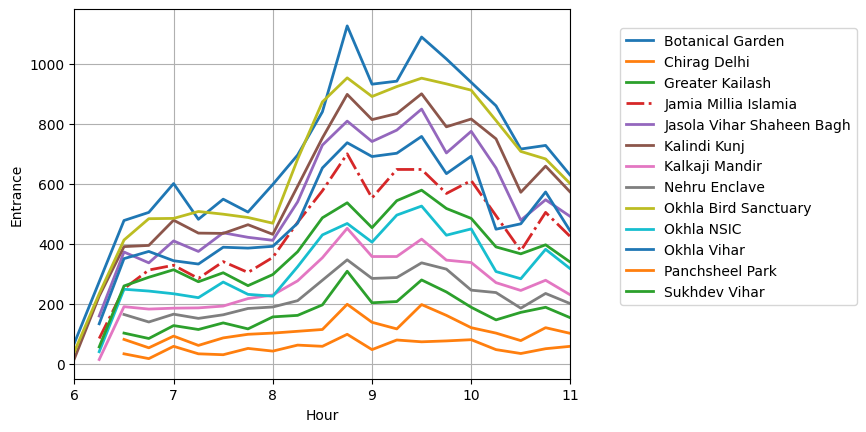

In [5]:
# Load the OD data for Line 2 (weekday scenario)
# travelers_df = pd.read_csv('{}/od_line6_2018-04-11.csv'.format(in_path))
travelers_df = pd.read_csv('{}/od_magenta_line_14_2023-08-20.csv'.format(in_path))

# Categorize departures into 15-minute intervals
travelers_df['departure_category'] = travelers_df['departure_time'] // 900 * 0.25

# Group by departure time category and entry station
travelers_grp = travelers_df.groupby(['departure_category', 'enter_station']).size().reset_index()

# Filter out early morning hours and the 'Kennedy' station for clearer visualization
travelers_grp = travelers_grp[(travelers_grp['departure_category'] >= 5.5) & (travelers_grp['enter_station'] != 'Janak Puri West')]

# Plot the number of passengers departing from each station over time
for nm, grp in travelers_grp.groupby('enter_station'):
    if nm == 'Jamia Millia Islamia': 
        plt.plot(grp['departure_category'].values, grp[0].values, lw=2, ls='-.', label=nm)
    else:
        plt.plot(grp['departure_category'].values, grp[0].values, lw=2, label=nm)

plt.grid()
plt.xlabel('Hour')
plt.ylabel('Entrance')
plt.xlim(6, 11)
plt.legend(loc=[1.1, 0.2])

# Save the figure as a PNG file with high resolution
plt.savefig('../figs/departure_plot.png', dpi=300, bbox_inches='tight')

##Looks like 'Castle Frank' is leading the charge this morning—probably folks rushing to get that last seat before the downtown squeeze!

### Train trajectories
This section of the code visualizes the movement of trains along Line 2 by plotting their trajectories over time against the stations they pass.

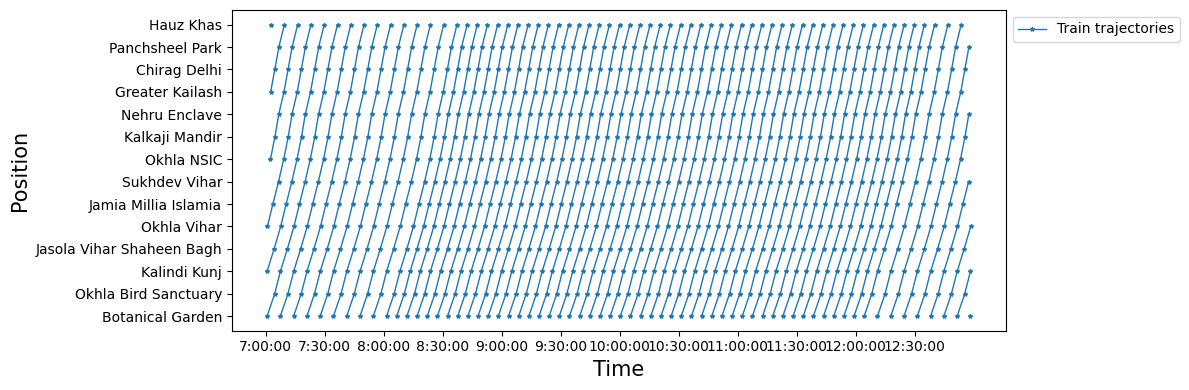

In [7]:
# Load and process the node (station) data
nodes = pd.read_csv('{}/{}_nodes.csv'.format(out_path, scen_nm))
nodes = nodes.sort_values(by='stop_lon', ascending=False)

# Calculate the x and y coordinates from the geometry data
nodes['x'] = nodes['geometry'].apply(lambda x: x.split('(')[1].split(' ')[0]).astype(float)
nodes['y'] = nodes['geometry'].apply(lambda x: x.split(')')[0].split(' ')[2]).astype(float)
stations_origin_x = float(nodes.iloc[0]['x'])
stations_origin_y = float(nodes.iloc[0]['y'])

# Calculate the distance of each station from the origin
nodes['distance'] = nodes.apply(lambda row: np.sqrt((row['x']-stations_origin_x)**2 + (row['y']-stations_origin_y)**2), axis=1)

# Filter to include only stations and reset the index
stations = nodes[nodes['type'] == 'station'].copy()
stations.reset_index(drop=True, inplace=True)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_yticks(stations.index)  # Align y-ticks with the station index
ax.set_yticklabels(stations['stop_id'])
ax.set_ylabel('Position', fontsize=15)

# Set the x-ticks to represent time from 6:00 AM to noon
x_ticks = np.arange(3600*7, 3600*13, 1800)
x_ticklabels = [str(datetime.timedelta(seconds=int(t))) for t in x_ticks]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticklabels)
ax.set_xlabel('Time', fontsize=15)

# Load the schedule data and filter for the upward direction during the specified time range
schedule = pd.read_csv('{}/{}_schedule.csv'.format(out_path, scen_nm))
schedule = schedule[schedule['location'].str.startswith('upward')]
schedule = schedule[(schedule['time'] >= 3600*7) & (schedule['time'] <= 3600*13)]

# Plot the train trajectories based on the schedule data
i = 0
for trip_id, grp in schedule.groupby('trip_id'):
    schedule_plot_list = []
    for row in grp[grp['status'] == 'stop'].itertuples():
        stop_id = getattr(row, 'location').split('-')[1]
        if stop_id in stations['stop_id'].values:
            station_index = stations[stations['stop_id'] == stop_id].index[0]
            schedule_plot_list.append([getattr(row, 'time'), station_index])

    schedule_plot_df = pd.DataFrame(schedule_plot_list, columns=['time', 'station_index'])
    if i == 0:
        ax.plot(schedule_plot_df['time'], schedule_plot_df['station_index'], '-*', lw=1, ms=3, c='C0', label='Train trajectories')
    else:
        ax.plot(schedule_plot_df['time'], schedule_plot_df['station_index'], '-*', lw=1, ms=3, c='C0')
    i += 1

# Add a legend and show the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

# Save the figure as a PNG file with high resolution
plt.savefig('../figs/train_trajectory.png', dpi=300, bbox_inches='tight')

plt.show()



##Tracking these trains look like a well-choreographed dance

### Traveler trajectory
This section of the code focuses on visualizing both the overall train trajectories and the journey of an individual traveler along Line 2. It plots the scheduled stops of trains alongside the traveler's journey, offering insights into how closely the traveler's movements align with the train schedule.

In [64]:
display(travelers_df.iloc[227910:227915])

,date,hour,entry_time,deal_time,enter_station,exit_station,travel_time,exit_type,departure_time,route_id,stop_sequence,traveler_id
227910,08-20-2023,8,08:07:53,08:32:50,Jamia Millia Islamia,Hauz Khas,25,0,30770,upward,5,227910
227911,08-20-2023,17,17:08:21,17:34:43,Jamia Millia Islamia,Hauz Khas,26,0,63283,upward,5,227911
227912,08-20-2023,16,16:41:30,17:04:55,Jamia Millia Islamia,Hauz Khas,23,0,61495,upward,5,227912
227913,08-20-2023,8,08:07:53,08:32:50,Jamia Millia Islamia,Hauz Khas,25,0,30770,upward,5,227913
227914,08-20-2023,17,17:01:52,17:25:11,Jamia Millia Islamia,Hauz Khas,23,0,62711,upward,5,227914


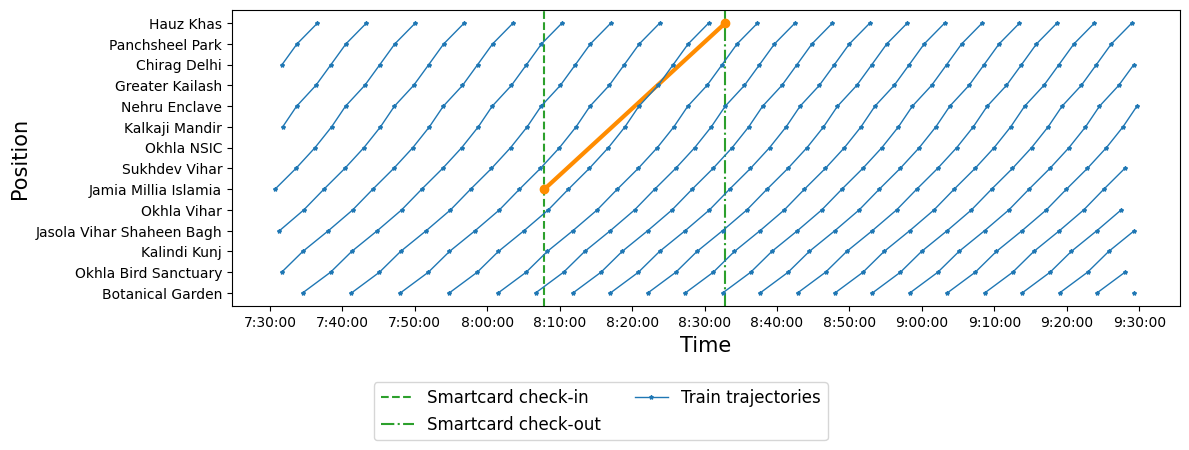

In [8]:
from datetime import timedelta

# Load and sort the node (station) data based on longitude
nodes = pd.read_csv('{}/{}_nodes.csv'.format(out_path, scen_nm))
nodes = nodes.sort_values(by='stop_lon', ascending=False)

# Calculate x, y coordinates from the geometry data and the distance from the origin
nodes['x'] = nodes['geometry'].apply(lambda x: x.split('(')[1].split(' ')[0]).astype(float)
nodes['y'] = nodes['geometry'].apply(lambda x: x.split(')')[0].split(' ')[2]).astype(float)
stations_origin_x = float(nodes.iloc[0]['x'])
stations_origin_y = float(nodes.iloc[0]['y'])
nodes['distance'] = nodes.apply(lambda row: np.sqrt((row['x']-stations_origin_x)**2 + (row['y']-stations_origin_y)**2), axis=1)

# Filter to include only stations and reset the index
stations = nodes[nodes['type'] == 'station'].copy()
stations.reset_index(drop=True, inplace=True)  # Align station index with plotting indices

# Create the plot for station positions and times
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_yticks(stations.index)  # Use DataFrame index aligned with sorting order
ax.set_yticklabels(stations['stop_id'])
ax.set_ylabel('Position', fontsize=15)

# Set the x-ticks to represent time intervals from 6:00 AM to 12:00 PM
x_ticks = np.arange(3600*6.5, 3600*12, 600)
# Now use timedelta in the code where you set the x-tick labels
x_ticklabels = [str(timedelta(seconds=int(t))) for t in x_ticks]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticklabels)
ax.set_xlabel('Time', fontsize=15)

# Load and filter the train schedule data for the upward direction during the specified time range
schedule = pd.read_csv('{}/{}_schedule.csv'.format(out_path, scen_nm))
schedule = schedule[schedule['location'].str.startswith('upward')]
schedule = schedule[(schedule['time'] >= 3600*7.5) & (schedule['time'] <= 3600*9.5)]

travelers_df = pd.read_csv('{}/od_magenta_line_14_2023-08-20.csv'.format(in_path))
travelers_df['traveler_id'] = travelers_df.index

# Plot the trace of an individual traveler
scen_nm_spec = 'dmrc'
traveler_id = 227913  # Example traveler ID
traveler_data = travelers_df[travelers_df['traveler_id'] == traveler_id]

## check in time and arrival time for individual traveler
traveler_to_trace = travelers_df[travelers_df['traveler_id']==traveler_id]
ftr = [3600,60,1]
checkin_time = traveler_to_trace.loc[traveler_id]['entry_time']
checkin_time = sum([a*b for a,b in zip(ftr, map(int,checkin_time.split(':')))])
ax.axvline(x=checkin_time, ls='--', c='C2', label='Smartcard check-in')
arrival_time = traveler_to_trace.loc[traveler_id]['deal_time']
arrival_time = sum([a*b for a,b in zip(ftr, map(int,arrival_time.split(':')))])
ax.axvline(x=arrival_time, ls='-.', c='C2', label='Smartcard check-out')

# Extract start and end times for the traveler's journey
start_time = traveler_data['entry_time'].iloc[0]
end_time = traveler_data['departure_time'].iloc[0]

# Convert times to seconds for plotting
from datetime import datetime
start_time_obj = datetime.strptime(start_time, '%H:%M:%S').time()
start_time = start_time_obj.hour * 3600 + start_time_obj.minute * 60 + start_time_obj.second

# Get station indices for start and end points
start_station_index = stations.index[stations['stop_id'] == traveler_data['enter_station'].iloc[0]].tolist()[0]
end_station_index = stations.index[stations['stop_id'] == traveler_data['exit_station'].iloc[0]].tolist()[0]

# Plot the traveler's journey
ax.plot([start_time, end_time], [start_station_index, end_station_index], '-o', lw=3, ms=5, color='darkorange')
ax.scatter([start_time], [start_station_index], color='darkorange', zorder=5)  # Mark start point
ax.scatter([end_time], [end_station_index], color='darkorange', zorder=5)  # Mark end point

# Plot the train trajectories from the schedule
i = 0
for trip_id, grp in schedule.groupby('trip_id'):
    schedule_plot_list = []
    for row in grp[grp['status'] == 'stop'].itertuples():
        stop_id = getattr(row, 'location').split('-')[1]
        if stop_id in stations['stop_id'].values:
            station_index = stations[stations['stop_id'] == stop_id].index[0]
            schedule_plot_list.append([getattr(row, 'time'), station_index])

    schedule_plot_df = pd.DataFrame(schedule_plot_list, columns=['time', 'station_index'])
    if i == 0:
        ax.plot(schedule_plot_df['time'], schedule_plot_df['station_index'], '-*', lw=1, ms=3, c='C0', label='Train trajectories')
    else:
        ax.plot(schedule_plot_df['time'], schedule_plot_df['station_index'], '-*', lw=1, ms=3, c='C0')
    i += 1

# Add legend and show the plot
plt.legend(loc=[0.15, -0.45], fontsize=12, ncol=2)
plt.tight_layout()

# Save the figure as a PNG file with high resolution
plt.savefig('../figs/traveler_trajectory.png', dpi=300, bbox_inches='tight')

plt.show()


In [6]:
# # Load and sort the node (station) data based on longitude
# nodes = pd.read_csv('{}/{}_nodes.csv'.format(out_path, scen_nm))
# nodes = nodes.sort_values(by='stop_lon', ascending=True)

# # Calculate x, y coordinates from the geometry data and the distance from the origin
# nodes['x'] = nodes['geometry'].apply(lambda x: x.split('(')[1].split(' ')[0]).astype(float)
# nodes['y'] = nodes['geometry'].apply(lambda x: x.split(')')[0].split(' ')[2]).astype(float)
# stations_origin_x = float(nodes.iloc[0]['x'])
# stations_origin_y = float(nodes.iloc[0]['y'])
# nodes['distance'] = nodes.apply(lambda row: np.sqrt((row['x']-stations_origin_x)**2 + (row['y']-stations_origin_y)**2), axis=1)

# # Filter to include only stations and reset the index
# stations = nodes[nodes['type']=='station'].copy()
# stations.reset_index(drop=True, inplace=True) # Align station index with plotting indices

# # Create the plot for station positions and times
# fig, ax = plt.subplots(figsize=(12, 5))
# ax.set_yticks(stations.index)  # Use DataFrame index which is aligned with the sorting order
# ax.set_yticklabels(stations['stop_id'])
# ax.set_ylabel('Position', fontsize=15)

# # Set the x-ticks to represent time intervals from 6:00 AM to 12:00 PM
# x_ticks = np.arange(3600*6.5, 3600*12, 600)  # 6 am for bus
# x_ticklabels = [str(datetime.timedelta(seconds=int(t))) for t in x_ticks]
# ax.set_xticks(x_ticks)
# ax.set_xticklabels(x_ticklabels)
# ax.set_xlabel('Time', fontsize=15)

# # Load and filter the train schedule data for the upward direction during the specified time range
# schedule = pd.read_csv('{}/{}_schedule.csv'.format(out_path, scen_nm))
# ## location starting with upward
# schedule = schedule[schedule['location'].str.startswith('upward')]  ## location starting with upward
# schedule = schedule[(schedule['time']>=3600*8) & (schedule['time']<=3600*9)]  ##schedule time 6 to 7

# ### get trace plot of individual travelers
# scen_nm_spec = 'ttcl2'

# ## 0 to 169,  23(27180 to 29700)
# traveler_id = 80

# # traveler_trace_list = []

# # for t in range(3600*6+300, 3600*9, 300):  #21600 to 42900         (route 10_10) 6 to 9
# #     # Check if the file exists
# #     if not os.path.exists('{}/traveler_outputs/status_change_{}_{}.csv'.format(out_path, output_scen_nm, t)): ## because route 10 buses are in gap
# #         continue
    
# #     status_change_df = pd.read_csv('{}/traveler_outputs/status_change_{}_{}.csv'.format(out_path, output_scen_nm, t))
# #     traveler_status_change_df = status_change_df[status_change_df['traveler_id']==traveler_id]
    
# #     if traveler_status_change_df.shape[0]>0:
# #         for row in traveler_status_change_df.itertuples():
# #             traveler_status = getattr(row, 'traveler_status')
# #             traveler_time = getattr(row, 'update_time')
# #             association = getattr(row, 'association')
# #             node_association = association
            
# #             # print('{}/traveler_outputs/status_change_{}_{}.csv'.format(out_path, output_scen_nm, t))
            
# #             if traveler_status == 3:
# #                 # print('yes')
# #                 node_association = schedule.loc[(schedule['trip_id']==association)
# #                                            & (schedule['time']<=traveler_time)
# #                                            & (schedule['next_time']>=traveler_time), 'location_id'].iloc[0]
# #             traveler_trace_list.append([traveler_id, traveler_status, traveler_time, node_association])


# # print(traveler_trace_list)

# # traveler_trace = pd.DataFrame(traveler_trace_list, columns=['traveler_id', 'traveler_status', 'update_time', 'node_association'])
# # traveler_trace = traveler_trace.sort_values(by='update_time', ascending=True)
# # traveler_trace = traveler_trace.merge(nodes[['node_id', 'distance']], how='left', left_on='node_association', right_on='node_id')
# # ax.plot(traveler_trace['update_time'], traveler_trace['distance'], '-o', lw=3, ms=5, c='C1', label='Traveler #{}'.format(traveler_id))


# ## check in time and arrival time for individual traveler
# travelers_df = pd.read_csv('{}/od_line_2_weekday_12.csv'.format(in_path))
# travelers_df['traveler_id'] = travelers_df.index
# traveler_to_trace = travelers_df[travelers_df['traveler_id']==traveler_id]
# ftr = [3600,60,1]
# checkin_time = traveler_to_trace.loc[traveler_id]['entry_time']
# checkin_time = sum([a*b for a,b in zip(ftr, map(int,checkin_time.split(':')))])
# ax.axvline(x=checkin_time, ls='--', c='C2', label='Smartcard check-in')
# arrival_time = traveler_to_trace.loc[traveler_id]['deal_time']
# arrival_time = sum([a*b for a,b in zip(ftr, map(int,arrival_time.split(':')))])
# ax.axvline(x=arrival_time, ls='-.', c='C2', label='Smartcard check-out')

# #Manual
# traveler_data = travelers_df[travelers_df['traveler_id'] == traveler_id]

# # Extract start_time and end_time
# start_time = traveler_data['entry_time'].iloc[0]
# end_time = traveler_data['departure_time'].iloc[0]

# from datetime import datetime
# start_time_obj = datetime.strptime(start_time, '%H:%M:%S').time()
# start_time = start_time_obj.hour * 3600 + start_time_obj.minute * 60 + start_time_obj.second

# # Station indices from the DataFrame
# start_station_index = stations.index[stations['stop_id'] == traveler_data['enter_station'].iloc[0]].tolist()[0]
# end_station_index = stations.index[stations['stop_id'] == traveler_data['exit_station'].iloc[0]].tolist()[0]

# # Plot the line for the journey
# ax.plot([start_time, end_time], [start_station_index, end_station_index], '-o', lw=3, ms=5, color='darkorange')

# # Optionally, add markers for start and end points
# ax.scatter([start_time], [start_station_index], color='darkorange', zorder=5)  # Start point
# ax.scatter([end_time], [end_station_index], color='darkorange', zorder=5)  # End point
# #Finish Manual

# i=0
# for trip_id, grp in schedule.groupby('trip_id'):
#     schedule_plot_list = []
#     for row in grp[grp['status']=='stop'].itertuples():
#         stop_id = getattr(row, 'location').split('-')[1]
#         if stop_id in stations['stop_id'].values:
#             # Find the index of the station in the 'stations' DataFrame
#             station_index = stations[stations['stop_id'] == stop_id].index[0]
#             schedule_plot_list.append([getattr(row, 'time'), station_index])

#     schedule_plot_df = pd.DataFrame(schedule_plot_list, columns=['time', 'station_index'])
#     if i == 0:
#         ax.plot(schedule_plot_df['time'], schedule_plot_df['station_index'], '-*', lw=1, ms=3, c='C0', label='Train trajectories')
#     else:
#         ax.plot(schedule_plot_df['time'], schedule_plot_df['station_index'], '-*', lw=1, ms=3, c='C0')
#     i += 1


# plt.legend(loc=[0.15, -0.45], fontsize=12, ncol=2)
# plt.tight_layout()
# # plt.savefig('../uregina/figs/trace_plot_{}.png'.format(traveler_id), dpi=200)

In [11]:
travelers_df = pd.read_csv('{}/od_magenta_line_14_2023-08-20.csv'.format(in_path))
travelers_df['traveler_id'] = travelers_df.index
display(travelers_df.head())

,date,hour,entry_time,deal_time,enter_station,exit_station,travel_time,exit_type,departure_time,route_id,stop_sequence,traveler_id
0,08-20-2023,19,19:32:14,19:43:08,Botanical Garden,Okhla Bird Sanctuary,11,0,70988,upward,0,0
1,08-20-2023,10,10:49:05,11:00:18,Botanical Garden,Okhla Bird Sanctuary,11,0,39618,upward,0,1
2,08-20-2023,8,08:50:01,08:59:29,Botanical Garden,Okhla Bird Sanctuary,9,0,32369,upward,0,2
3,08-20-2023,14,14:41:53,14:53:24,Botanical Garden,Okhla Bird Sanctuary,12,0,53604,upward,0,3
4,08-20-2023,18,18:05:39,18:14:27,Botanical Garden,Okhla Bird Sanctuary,9,0,65667,upward,0,4


In [12]:
# traveler_id_df = travelers_df[travelers_df['enter_station'].str.startswith('H') & travelers_df['exit_station'].str.startswith('H')]
# traveler_id_df

### Platform crowdedness
This code snippet is used to analyze the crowdedness of different platforms across various scenarios by aggregating traveler data over time.

In [13]:
# Define the platform crowdness dictionary for different scenarios
platform_crowdness_dict = {
    'magenta_line_14_2023_1800_wt90-90': None,  # Example scenario: Line 2 with specific walking time parameters
}

platform_crowdness = []

# Loop through each scenario and time interval to aggregate platform data
for scen_nm_spec in platform_crowdness_dict.keys():
    for t in range(3600*6+1800, 3600*11, 20):  # Time range from 7:00 AM to 11:00 AM, with 20-second intervals
        traveler_locations = pd.read_csv(
            '{}/traveler_outputs/agg_traveler_outputs_{}_{}.csv'.format(out_path, scen_nm_spec, t))
        
        traveler_locations['time'] = t  # Add current time to the DataFrame
        traveler_locations['scen_nm'] = scen_nm_spec  # Add scenario name to the DataFrame
        
        # Filter for travelers who are currently on the platform (status 2)
        platform_crowdness += traveler_locations[traveler_locations['traveler_status'] == 2].values.tolist()

# Convert the collected data into a DataFrame for further analysis
platform_crowdness = pd.DataFrame(platform_crowdness,
                                  columns=['traveler_status', 'platform_name', 'num_travelers', 'time', 'scen_nm'])

# Display the first few rows of the DataFrame to verify the results
# platform_crowdness.head()

#### Individual platform
This code visualizes the crowdedness at a specific platform over time, comparing it with the train arrival schedule. It provides insights into how traveler density fluctuates at the platform, especially during peak hours.

In [14]:
# Read the CSV file
sc_df = pd.read_csv('../transit_sim_inputs/od_magenta_line_14_2023-08-20.csv')

# Count occurrences of each route_num
platform_counts = sc_df['enter_station'].value_counts()
print(platform_counts)

enter_station
Botanical Garden             47322
Okhla Bird Sanctuary         44048
Kalindi Kunj                 39971
Jasola Vihar Shaheen Bagh    36429
Okhla Vihar                  33009
Jamia Millia Islamia         29241
Sukhdev Vihar                25298
Okhla NSIC                   21700
Kalkaji Mandir               18192
Nehru Enclave                14601
Greater Kailash              10958
Chirag Delhi                  7287
Panchsheel Park               3654
Name: count, dtype: int64


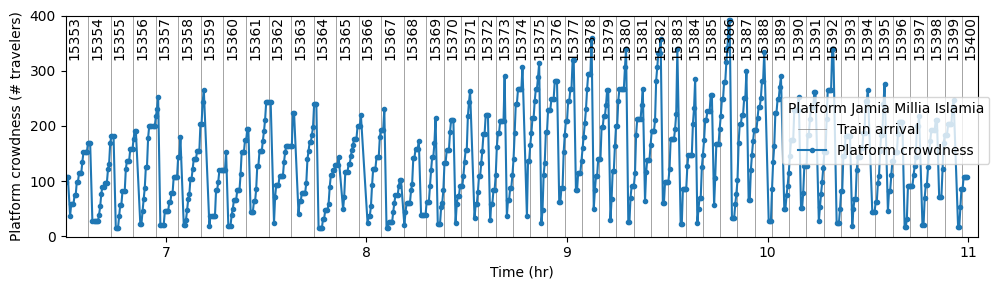

In [15]:
### Retrieve platform data
platform_nm, platform_nm_text = (1, 'upward-Jamia Millia Islamia')  # Example platform for visualization

### Initialize plotting
fig, ax = plt.subplots(figsize=(10, 3))  # Set the figure size

### Retrieve and process schedule data
schedule = pd.read_csv('{}/dmrc_schedule.csv'.format(out_path))
single_platform_schedule = schedule[(schedule['location'] == platform_nm_text) & (schedule['status'] == 'stop')].copy()
single_platform_schedule = single_platform_schedule.sort_values(by='time', ascending=True)
single_platform_schedule['interval'] = np.round((single_platform_schedule['time'].shift(-1) - single_platform_schedule['time'])/60, 1)
single_platform_schedule['hour'] = single_platform_schedule['time']/3600

# Annotate train arrivals on the plot
for row in single_platform_schedule.itertuples():
    x_position = getattr(row, 'time') / 3600
    ax.axvline(x_position, -100, 600, lw=0.5, c='gray')  # Vertical line for each train arrival
    ax.annotate(getattr(row, 'trip_id'), (x_position + 0.01, 325),  # Annotate with trip_id
                rotation=90, fontsize=10, color='black')

ax.axvline(7, 0, 0, lw=0.5, c='gray', label='Train arrival')  # Mark 7 AM as a reference point

### Plot platform crowdedness
for scen_nm_spec in platform_crowdness_dict.keys():
    single_platform = platform_crowdness[(platform_crowdness['platform_name'] == platform_nm) & (
        platform_crowdness['scen_nm'] == scen_nm_spec)].copy()
    
    ax.plot(single_platform['time']/3600, single_platform['num_travelers'], '.-', c='C0', label='Platform crowdness')
    single_platform['hour'] = single_platform['time']/3600

# Set axis limits and labels
ax.set_xlim([6.5, 11.05])  # Time range from 6:30 AM to 11:00 AM
ax.set_ylim([-1, 400])  # Adjusted y-axis for better visibility
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Platform crowdness (# travelers)')
fig.legend(ncol=1, bbox_to_anchor=(0.78, 0.55), loc='center left', title='Platform {}'.format(platform_nm_text.split('-')[1]), fontsize=10)

plt.tight_layout()
plt.savefig('../figs/platform_crowdness_{}.png'.format(platform_nm_text), dpi=300)  # Save the plot

#### All platforms

In [185]:
# fig, ax = plt.subplots(figsize=(10, 4))
# for platform_name, grp in platform_crowdness.groupby('platform_name'):
#     ax.plot(grp['time']/3600, grp['num_travelers'], '.-', label=platform_name)
# ax.set_xlim([t_start/3600, t_end/3600])
# ax.set_ylim([-100, 1800])
# ax.set_xlabel('Time (hr)')
# ax.set_ylabel('Platform crowdness (# travelers)')
# fig.legend(ncol=2, bbox_to_anchor=(0.9, 0.5), loc='center left', title='platform')

### Train occupancy
This section of the code is focused on tracking the occupancy of trains during the simulation. The occupancy data is collected for each time step, filtered by scenario, and aggregated into a comprehensive dataframe.

In [16]:
# Define the dictionary for storing train occupancy data for different scenarios
train_occupancy_dict = {
    # 'line6_2018-04-11_1960_wt90-90': None
    'magenta_line_14_2023_1800_wt90-90': None
}

# Loop through each scenario to collect train occupancy data
for scen_nm in train_occupancy_dict.keys():
    train_occupancy = []
    
    # Iterate over time from 7 AM to 10 AM in 20-second intervals
    for t in range(3600*7, 3600*10, 20):
        # Read traveler locations at the current time
        traveler_locations = pd.read_csv(
            '{}/traveler_outputs/agg_traveler_outputs_{}_{}.csv'.format(out_path, scen_nm, t))
        traveler_locations['time'] = t
        
        # Filter for travelers who are on a train (status = 3)
        traveler_locations = traveler_locations[traveler_locations['traveler_status']==3]
        traveler_locations['trip_id'] = traveler_locations['association'].astype(int)

        # Read train positions at the current time
        train_positions = pd.read_csv('{}/train_outputs/train_outputs_{}_{}.csv'.format(out_path, scen_nm, t))
        train_positions['train_status'] = train_positions['status']
        
        # Merge traveler data with train positions based on trip_id
        traveler_locations = traveler_locations.merge(
            train_positions[['trip_id', 'train_status', 'location']],
            how='right', on='trip_id')
        traveler_locations['time'] = t
        
        # Append the merged data to the train occupancy list
        train_occupancy += traveler_locations[['traveler_status', 'trip_id', 'num_travelers',
                                               'time', 'train_status', 'location']].values.tolist()

    # Convert the train occupancy list to a DataFrame and store it in the dictionary
    train_occupancy = pd.DataFrame(train_occupancy, 
                                   columns=['traveler_status', 'trip_id', 'num_travelers', 'time', 
                                            'train_status', 'location'])
    train_occupancy_dict[scen_nm] = train_occupancy

#### Individual train
This code visualizes the occupancy levels of a specific train during its run, including the number of passengers on board and the train's interactions with different platforms.

In [17]:
# Load the GTFS stop times data for Line 2 in the upward direction
df = pd.read_csv('../inputs/gtfs_magenta_line_stop_times_14_upward.csv')

# Count occurrences of each 'trip_id' in the DataFrame
trip_id_counts = df['trip_id'].value_counts()

# Display the counts of the top 10 most frequent 'trip_id'
print(trip_id_counts.head(10))

trip_id
15351    14
15471    14
15463    14
15464    14
15465    14
15466    14
15467    14
15468    14
15469    14
15470    14
Name: count, dtype: int64


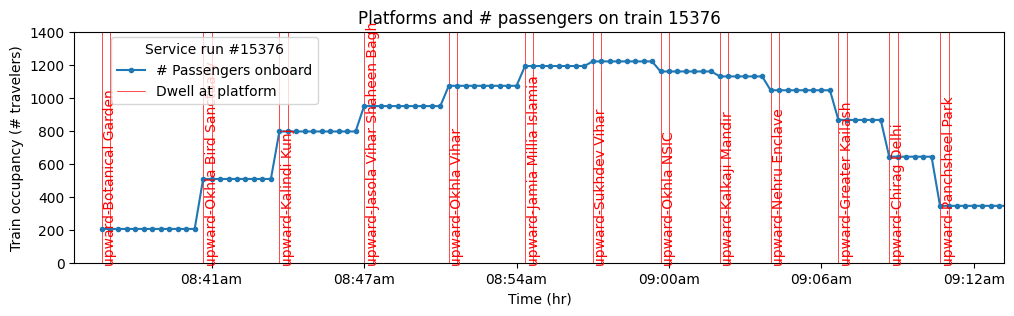

In [18]:
# Retrieve individual train data for a specific trip ID
trip_id = 15376  # Example trip ID for analysis

# Create a figure for plotting
fig, ax = plt.subplots(figsize=(12, 3))

# Plot train occupancy data
for scen_nm, train_occupancy in train_occupancy_dict.items():
    single_train = train_occupancy[train_occupancy['trip_id'] == trip_id]

    # Mark platform names on the plot
    for row in single_train.groupby(['train_status', 'location']).agg({'time': 'first'}).reset_index().itertuples():
        ax.axvline(getattr(row, 'time') / 3600, -100, 600, lw=0.5, c='r')
        if getattr(row, 'train_status') == 'on_link':
            continue
        ax.annotate(getattr(row, 'location'), (getattr(row, 'time') / 3600 + 0.001, 0), rotation=90, fontsize=10, c='r')
    
    ax.plot(single_train['time'] / 3600, single_train['num_travelers'], '.-', label='# Passengers onboard')

ax.axvline(7, 0, 0, lw=0.5, c='r', label='Dwell at platform')

# Adjust the x-axis limits based on the data
if not single_train.empty:
    max_time = np.max(single_train['time']) if np.isfinite(np.max(single_train['time'])) else 0
    # ax.set_xlim([8.65, max_time / 3600 + 0.1])
    ax.set_xlim([8.61, 9.22])

# Format x-axis labels as time (AM/PM)
fmt = lambda t, pos: '{:02}:{:02}am'.format(int(float(t) * 3600 // 3600), int((float(t) * 3600 % 3600) // 60))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt))

# Set plot labels and limits
ax.set_ylim([-1, 1400])
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Train occupancy (# travelers)')
lgd = fig.legend(ncol=1, bbox_to_anchor=(0.15, 0.75), loc='center left', title='Service run #{}'.format(trip_id), fontsize=10)

# Add a title and save the plot
plt.title('Platforms and # passengers on train {}'.format(trip_id))
plt.savefig('../figs/train_occupancy_tripid_{}_before.png'.format(trip_id), dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')

#### All trains

In [199]:
# train_occupancy = train_occupancy_dict['changping_line_validation_0528_cap1610']
# display(train_occupancy[train_occupancy['num_travelers']>1609].groupby(['trip_id', 'train_status', 'location']).size())
# print(train_occupancy['trip_id'].nunique())

# fig, ax = plt.subplots(figsize=(10, 4))
# for trip_id, grp in train_occupancy.groupby('trip_id'):
#     # if np.max(grp['num_travelers'])<1459: continue
#     ax.plot(grp['time']/3600, grp['num_travelers'], '.-', label=trip_id)
# ax.set_xlim([t_start/3600, t_end/3600+0.2])
# ax.set_ylim([-100, 1800])
# ax.set_xlabel('Time (hr)')
# ax.set_ylabel('Train occupancy (# travelers)')
# fig.legend(ncol=5, bbox_to_anchor=(0.9, 0.5), loc='center left', title='trip_id')

In [19]:
df_update= pd.read_csv("../data/train.csv")
df_update = df_update[['deal_time','update_time']]
# df_update.head()

In [20]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

reg = LinearRegression()
reg.fit(np.array(df_update['deal_time']).reshape(-1, 1), np.array(df_update['update_time']))

rf = RandomForestRegressor()
rf.fit(np.array(df_update['deal_time']).reshape(-1, 1), np.array(df_update['update_time']))

dt = DecisionTreeRegressor(random_state=42)
dt.fit(np.array(df_update['deal_time']).reshape(-1, 1), np.array(df_update['update_time']))

svm = SVR()
svm.fit(np.array(df_update['deal_time']).reshape(-1, 1), np.array(df_update['update_time']))

SVR()

In [ ]:
# print(reg.coef_)
# print(reg.intercept_)

### Comparing Simulated and Smartcard Travel Times
This code compares the arrival times recorded by smartcard data against those predicted by a simulation

### Validation plot


### 6:00-6:30

C:\Users\faraz\AppData\Local\Temp\ipykernel_24480\1512363814.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  traveler_output_sample['deal_time'] = pd.to_datetime(traveler_output_sample['deal_time'].fillna('00:00:00'))


,traveler_id,origin_nid,destin_nid,departure_time,trip_distance,traveler_status,update_time,association,next_station_id,init_boarding_time,final_alighting_time,aboard_tmp,remain_cap,order,train_location_id,deal_time,time_sim,time_card,time_diff
0,31,14,23,25274,842.0,4,25351.8,1,-111,25660.0,26000.0,False,0,10000000.0,-1,25274,0.201667,0.0,-0.201667
1,35,14,23,22349,842.0,4,22421.4,1,-111,22820.0,23160.0,False,0,10000000.0,-1,22349,0.225278,0.0,-0.225278
2,50,14,23,25756,842.0,4,25801.2,1,-111,26060.0,26400.0,False,0,10000000.0,-1,25756,0.178889,0.0,-0.178889
3,68,14,23,24029,842.0,4,24010.4,1,-111,24440.0,24780.0,False,0,10000000.0,-1,24029,0.208611,0.0,-0.208611
4,74,14,23,25274,842.0,4,25351.8,1,-111,25660.0,26000.0,False,0,10000000.0,-1,25274,0.201667,0.0,-0.201667


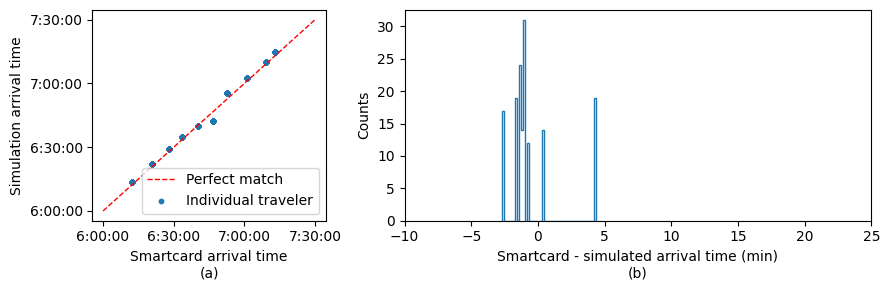

In [23]:
from datetime import timedelta

scen_nm_spec = 'dmrc'

### Read OD inputs
travelers_df = pd.read_csv('{}/od_magenta_line_14_2023-08-20.csv'.format(in_path))
travelers_df['traveler_id'] = travelers_df.index

# Sample the OD data
od_sample = travelers_df.loc[
    (travelers_df['departure_time'] >= 6.15 * 3600) & 
    (travelers_df['departure_time'] < 7.28 * 3600) &
    (travelers_df['exit_type'] == 0) & 
    (travelers_df['enter_station'] != travelers_df['exit_station'])
].head(150)

### Read traveler outputs
traveler_output = pd.read_csv('{}/traveler_outputs/final_traveler_status_{}.csv'.format(out_path, output_scen_nm))

### Merge OD inputs with simulation results
traveler_output_sample = traveler_output.merge(od_sample[['traveler_id', 'deal_time']], how='right', on='traveler_id')
traveler_output_sample['deal_time'] = pd.to_datetime(traveler_output_sample['deal_time'].fillna('00:00:00'))
traveler_output_sample['deal_time'] = (traveler_output_sample['deal_time'] - traveler_output_sample['deal_time'].dt.normalize()).dt.total_seconds().astype(int)

# Calculate time differences
traveler_output_sample['time_sim'] = traveler_output_sample['update_time'] / 3600 - traveler_output_sample['departure_time'] / 3600
traveler_output_sample['time_card'] = traveler_output_sample['deal_time'] / 3600 - traveler_output_sample['departure_time'] / 3600
traveler_output_sample['time_diff'] = -traveler_output_sample['update_time'] / 3600 + traveler_output_sample['deal_time'] / 3600

### Predict update times using Random Forest model
rf_array = rf.predict(np.array(traveler_output_sample['deal_time']).reshape(-1, 1))
traveler_output_sample['update_time'] = rf_array
display(traveler_output_sample[traveler_output_sample['time_diff']<-0.1].head())
traveler_output_sample['time_diff'] = -traveler_output_sample['update_time'] / 3600 + traveler_output_sample['deal_time'] / 3600

### Plotting the results
fig = plt.figure(figsize=(9, 3))
gs = GridSpec(1, 2, width_ratios=[1, 2])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# Scatter plot comparing smartcard and simulated arrival times
ax1.plot([3600 * 6, 3600 * 7.5], [3600 * 6, 3600 * 7.5], ls='--', lw=1, c='r', label='Perfect match')
ax1.scatter(traveler_output_sample['deal_time'], traveler_output_sample['update_time'], s=10, label='Individual traveler')
x_ticks = np.arange(3600 * 6, 3600 * 7.51, 1800)
x_ticklabels = [str(timedelta(seconds=int(t))) for t in x_ticks]
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_ticklabels)
ax1.set_xlabel('Smartcard arrival time\n(a)', fontsize=10)
ax1.set_yticks(x_ticks)
ax1.set_yticklabels(x_ticklabels)
ax1.set_ylabel('Simulation arrival time', fontsize=10)

# Histogram of the time differences
ax2.hist(traveler_output_sample['time_diff'] * 60, histtype=u'step', bins=45)
x_ticks = np.arange(-10, 30, 5)
x_ticklabels = [str(timedelta(seconds=int(t))) for t in x_ticks]
ax2.set_xticks(x_ticks)
ax2.set_xlabel('Smartcard - simulated arrival time (min)\n(b)', fontsize=10)
ax2.set_ylabel('Counts', fontsize=10)

ax1.legend()
plt.tight_layout()

# Save the figure as a PNG file with high resolution
plt.savefig('../figs/validation_plot.png', dpi=300, bbox_inches='tight')

In [104]:
# scen_nm_spec = 'bjl6'

# ### read OD inputs
# # travelers_df = pd.read_csv('{}/od_line6_2018-04-11.csv'.format(in_path))
# travelers_df = pd.read_csv('{}/od_bus_route_10_10_weekday.csv'.format(in_path))

# travelers_df['traveler_id'] = travelers_df.index

# # display(travelers_df)

# od_sample = travelers_df.loc[(travelers_df['departure_time']>=6*3600) 
#                          & (travelers_df['departure_time']<7.5*3600) ##7
#                          & (travelers_df['exit_type']==0) ##0
#                          & (travelers_df['enter_station']!=travelers_df['exit_station'])]

# # print(od_sample)

# ### read traveler outputs
# traveler_output = pd.read_csv(
#         '{}/traveler_outputs/final_traveler_status_{}.csv'.format(out_path, output_scen_nm))
# # traveler_output_sample = traveler_output.loc[
# #         (traveler_output['traveler_status']==4) & 
# #         #(traveler_output['exit_type']==1) & 
# #         (traveler_output['final_alighting_time']<=12*3600)].copy()

# ### merge the two
# traveler_output_sample = traveler_output.merge(od_sample[['traveler_id', 'deal_time']], how='right', on='traveler_id')

# traveler_output_sample['deal_time'] = pd.to_datetime(traveler_output_sample['deal_time'].fillna('00:00:00'))
# traveler_output_sample['deal_time'] = (traveler_output_sample['deal_time']-traveler_output_sample['deal_time'].dt.normalize()
#                                ).dt.total_seconds().astype(int)

# traveler_output_sample['time_sim'] = traveler_output_sample['update_time']/3600 - traveler_output_sample['departure_time']/3600
# traveler_output_sample['time_card'] = traveler_output_sample['deal_time']/3600 - traveler_output_sample['departure_time']/3600
# traveler_output_sample['time_diff'] = - traveler_output_sample['update_time']/3600 + traveler_output_sample['deal_time']/3600

# # traveler_output_sample = traveler_output_sample[traveler_output_sample['time_card']<0.5]
# # traveler_output_sample = traveler_output_sample[(traveler_output_sample['time_sim']>0) & (traveler_output_sample['time_sim']<1.5)]

# display(traveler_output_sample[traveler_output_sample['time_diff']<-0.1])
# print(traveler_output_sample.shape)

# fig = plt.figure(figsize=(9, 3))
# gs = GridSpec(1, 2, width_ratios=[1, 2])
# ax1 = fig.add_subplot(gs[0])
# ax2 = fig.add_subplot(gs[1])

# ax1.plot([3600*6, 3600*7.5], [3600*6, 3600*7.5], ls='--', lw=1, c='r', label='Perfect match')
# ax1.scatter(traveler_output_sample['deal_time'], traveler_output_sample['update_time'], s=10, label='Individual traveler')
# x_ticks = np.arange(3600*6, 3600*7.51, 1800)
# x_ticklabels = [str(datetime.timedelta(seconds=int(t))) for t in x_ticks]
# ax1.set_xticks(x_ticks)
# ax1.set_xticklabels(x_ticklabels)
# ax1.set_xlabel('Smartcard arrival time\n(a)', fontsize=10)
# ax1.set_yticks(x_ticks)
# ax1.set_yticklabels(x_ticklabels)
# ax1.set_ylabel('Simulation arrival time', fontsize=10)
# # ax1.set_aspect('equal')

# ax2.hist(traveler_output_sample['time_diff']*60, histtype=u'step', bins=45)
# x_ticks = np.arange(-5, 45, 5)
# x_ticklabels = [str(datetime.timedelta(seconds=int(t))) for t in x_ticks]
# ax2.set_xticks(x_ticks)
# ax2.set_xlabel('Smartcard - simulated arrival time (min)\n(b)', fontsize=10)
# ax2.set_ylabel('Counts', fontsize=10)

# ax1.legend()
# plt.tight_layout()
# # plt.savefig('../uregina/figs/0600-0630_verification.png', dpi=200)

### All scenarios
This section involves loading, merging, and validating the travel time data from various scenarios. It compares simulated travel times against recorded smartcard data across different configurations, such as varying train capacities and walking times.

In [91]:
# ### simulated and smartcard travel time

# ### Define validation scenarios with different capacities and walking times
# validation_dict = {
#     'line_2_weekday_1960_wt90-90': None,
    
#     'line_2_weekday_validation_cap10000_wt0-0': None,
#     'line_2_weekday_validation_cap1960_wt0-0': None,
    
#     'line_2_weekday_validation_cap2100_wt50-50': None,
#     'line_2_weekday_validation_cap2300_wt50-50': None,
#     'line_2_weekday_validation_cap2500_wt50-50': None,
    
#     'line_2_weekday_validation_cap2300_wt90-50': None,
#     'line_2_weekday_validation_cap2300_wt70-50': None,
# }

# ### Read OD input data
# od_input = pd.read_csv('{}/od_{}.csv'.format(in_path, demand_scen_nm))
# od_input = od_input[od_input['enter_station'] != od_input['exit_station']].reset_index(drop=True)
# print(od_input.shape, od_input[od_input['exit_type'] == 0].shape)  # Checking shape after filtering

# ### Read and merge simulated travel time outputs for each scenario
# for scen_nm_spec in validation_dict.keys():
#     traveler_output = pd.read_csv(
#         '../transit_sim_outputs/{}/traveler_outputs/final_traveler_status_{}.csv'.format(scen_nm_spec, scen_nm_spec))
#     print(traveler_output.shape)

#     # Prepare the 'deal_time' and merge OD input data with traveler outputs
#     od_input['deal_time'] = od_input['deal_time'].fillna('00:00:00')
#     traveler_output['deal_time'] = pd.to_datetime(od_input['deal_time'])
#     traveler_output['deal_time'] = (traveler_output['deal_time'] - traveler_output['deal_time'].dt.normalize()).dt.total_seconds().astype(int)
    
#     # Merge additional OD input columns into the traveler output
#     traveler_output['exit_type'] = od_input['exit_type']
#     traveler_output['enter_station'] = od_input['enter_station']
#     traveler_output['exit_station'] = od_input['exit_station']

#     # Store the merged data for each scenario
#     validation_dict[scen_nm_spec] = traveler_output

(227764, 12) (227764, 12)
(227764, 15)


/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/2176073935.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  traveler_output['deal_time'] = pd.to_datetime(od_input['deal_time'])


(227764, 15)


/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/2176073935.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  traveler_output['deal_time'] = pd.to_datetime(od_input['deal_time'])


(227764, 15)


/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/2176073935.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  traveler_output['deal_time'] = pd.to_datetime(od_input['deal_time'])


(227764, 15)


/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/2176073935.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  traveler_output['deal_time'] = pd.to_datetime(od_input['deal_time'])


(227764, 15)


/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/2176073935.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  traveler_output['deal_time'] = pd.to_datetime(od_input['deal_time'])


(227764, 15)


/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/2176073935.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  traveler_output['deal_time'] = pd.to_datetime(od_input['deal_time'])


(227764, 15)


/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/2176073935.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  traveler_output['deal_time'] = pd.to_datetime(od_input['deal_time'])


(227764, 15)


/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/2176073935.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  traveler_output['deal_time'] = pd.to_datetime(od_input['deal_time'])


In [807]:
# counts = traveler_output['traveler_status'].value_counts()
# print(counts)

# check = traveler_output[
#         (traveler_output['traveler_status']==4) & ## 4
#         (traveler_output['exit_type']==0) & ##1
#         (traveler_output['deal_time']<=12*3600)]

# display(check)

In [92]:
# for scen_nm_spec in validation_dict.keys():
#     traveler_output = validation_dict[scen_nm_spec]

#     # Filter for travelers with specific statuses and conditions
#     validation_set = traveler_output[
#         (traveler_output['traveler_status'] == 4) &  # Traveler has exited
#         (traveler_output['exit_type'] == 0) &  # Valid exit type
#         (traveler_output['deal_time'] <= 12*3600)  # Deal time before noon
#     ].copy()
#     print(validation_set.shape)

#     # Calculate simulated and smartcard-based travel times
#     validation_set['time_sim'] = validation_set['update_time'] / 3600 - validation_set['departure_time'] / 3600
#     validation_set['time_card'] = validation_set['deal_time'] / 3600 - validation_set['departure_time'] / 3600
#     validation_set['time_diff'] = - validation_set['update_time'] / 3600 + validation_set['deal_time'] / 3600
    
#     # Exclude entries with unrealistic smartcard travel times
#     validation_set = validation_set.loc[validation_set['time_card'] < 0.5]
#     validation_set = validation_set.loc[(validation_set['time_sim'] > 0) & (validation_set['time_sim'] < 1.5)]

#     # Optional: filter by specific time range or station (commented out)
#     # validation_set = validation_set[(validation_set['departure_time'] > 7.5*3600) & (validation_set['departure_time'] < 8.5*3600)]
#     # validation_set = validation_set[(validation_set['enter_station'] == 'shahe') & (validation_set['exit_station'] == 'xierqi')]

#     ### Compute validation statistics
#     validation_stat = validation_set.copy()
#     validation_stat['departure_grp'] = np.where(validation_set['departure_time'] < 3600*7.5, 'sp_before',
#                                                 np.where(validation_set['departure_time'] <= 3600*8.75, 'pp', 'sp_after'))
#     validation_stat['time_diff_min'] = validation_stat['time_diff'] * 60
#     validation_stat = validation_stat.groupby('departure_grp').agg({'time_diff_min': ['size', np.mean, np.median, np.std]})
#     print(scen_nm_spec)
#     display(validation_stat.round(2))
    
#     validation_dict[scen_nm_spec] = validation_set


(93959, 19)
line_2_weekday_1960_wt90-90


/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/3310960866.py:30: FutureWarning: The provided callable <function mean at 0x10e2785e0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  validation_stat = validation_stat.groupby('departure_grp').agg({'time_diff_min': ['size', np.mean, np.median, np.std]})
/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/3310960866.py:30: FutureWarning: The provided callable <function median at 0x10e3bd6c0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  validation_stat = validation_stat.groupby('departure_grp').agg({'time_diff_min': ['size', np.mean, np.median, np.std]})
/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/3310960866.py:30: FutureWarning: The pr

time_diff_min                    
                       size   mean median   std
departure_grp                                  
pp                    38041 -11.46 -10.70  4.71
sp_after              33863 -11.31 -10.58  4.76
sp_before             22055 -11.42 -10.70  4.57

(94264, 19)
line_2_weekday_validation_cap10000_wt0-0


/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/3310960866.py:30: FutureWarning: The provided callable <function mean at 0x10e2785e0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  validation_stat = validation_stat.groupby('departure_grp').agg({'time_diff_min': ['size', np.mean, np.median, np.std]})
/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/3310960866.py:30: FutureWarning: The provided callable <function median at 0x10e3bd6c0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  validation_stat = validation_stat.groupby('departure_grp').agg({'time_diff_min': ['size', np.mean, np.median, np.std]})
/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/3310960866.py:30: FutureWarning: The pr

time_diff_min                   
                       size  mean median   std
departure_grp                                 
pp                    38041 -8.47  -7.28  4.74
sp_after              34168 -8.29  -6.98  4.75
sp_before             22055 -8.38  -7.20  4.63

(94264, 19)
line_2_weekday_validation_cap1960_wt0-0


/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/3310960866.py:30: FutureWarning: The provided callable <function mean at 0x10e2785e0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  validation_stat = validation_stat.groupby('departure_grp').agg({'time_diff_min': ['size', np.mean, np.median, np.std]})
/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/3310960866.py:30: FutureWarning: The provided callable <function median at 0x10e3bd6c0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  validation_stat = validation_stat.groupby('departure_grp').agg({'time_diff_min': ['size', np.mean, np.median, np.std]})
/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/3310960866.py:30: FutureWarning: The pr

time_diff_min                   
                       size  mean median   std
departure_grp                                 
pp                    38041 -8.47  -7.28  4.74
sp_after              34168 -8.29  -6.98  4.75
sp_before             22055 -8.38  -7.20  4.63

(94401, 19)
line_2_weekday_validation_cap2100_wt50-50


/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/3310960866.py:30: FutureWarning: The provided callable <function mean at 0x10e2785e0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  validation_stat = validation_stat.groupby('departure_grp').agg({'time_diff_min': ['size', np.mean, np.median, np.std]})
/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/3310960866.py:30: FutureWarning: The provided callable <function median at 0x10e3bd6c0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  validation_stat = validation_stat.groupby('departure_grp').agg({'time_diff_min': ['size', np.mean, np.median, np.std]})
/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/3310960866.py:30: FutureWarning: The pr

time_diff_min                    
                       size   mean median   std
departure_grp                                  
pp                    38041 -10.16  -9.20  4.69
sp_after              34305  -9.98  -8.82  4.72
sp_before             22055 -10.12  -9.25  4.67

(94401, 19)
line_2_weekday_validation_cap2300_wt50-50


/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/3310960866.py:30: FutureWarning: The provided callable <function mean at 0x10e2785e0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  validation_stat = validation_stat.groupby('departure_grp').agg({'time_diff_min': ['size', np.mean, np.median, np.std]})
/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/3310960866.py:30: FutureWarning: The provided callable <function median at 0x10e3bd6c0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  validation_stat = validation_stat.groupby('departure_grp').agg({'time_diff_min': ['size', np.mean, np.median, np.std]})
/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/3310960866.py:30: FutureWarning: The pr

time_diff_min                    
                       size   mean median   std
departure_grp                                  
pp                    38041 -10.16  -9.20  4.69
sp_after              34305  -9.98  -8.82  4.72
sp_before             22055 -10.12  -9.25  4.67

(94401, 19)
line_2_weekday_validation_cap2500_wt50-50


/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/3310960866.py:30: FutureWarning: The provided callable <function mean at 0x10e2785e0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  validation_stat = validation_stat.groupby('departure_grp').agg({'time_diff_min': ['size', np.mean, np.median, np.std]})
/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/3310960866.py:30: FutureWarning: The provided callable <function median at 0x10e3bd6c0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  validation_stat = validation_stat.groupby('departure_grp').agg({'time_diff_min': ['size', np.mean, np.median, np.std]})
/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/3310960866.py:30: FutureWarning: The pr

time_diff_min                    
                       size   mean median   std
departure_grp                                  
pp                    38041 -10.16  -9.20  4.69
sp_after              34305  -9.98  -8.82  4.72
sp_before             22055 -10.12  -9.25  4.67

(94334, 19)
line_2_weekday_validation_cap2300_wt90-50


/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/3310960866.py:30: FutureWarning: The provided callable <function mean at 0x10e2785e0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  validation_stat = validation_stat.groupby('departure_grp').agg({'time_diff_min': ['size', np.mean, np.median, np.std]})
/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/3310960866.py:30: FutureWarning: The provided callable <function median at 0x10e3bd6c0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  validation_stat = validation_stat.groupby('departure_grp').agg({'time_diff_min': ['size', np.mean, np.median, np.std]})
/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/3310960866.py:30: FutureWarning: The pr

time_diff_min                    
                       size   mean median   std
departure_grp                                  
pp                    38041 -11.46 -10.70  4.70
sp_after              34238 -10.15  -9.10  4.73
sp_before             22055 -10.98 -10.22  4.67

(94323, 19)
line_2_weekday_validation_cap2300_wt70-50


/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/3310960866.py:30: FutureWarning: The provided callable <function mean at 0x10e2785e0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  validation_stat = validation_stat.groupby('departure_grp').agg({'time_diff_min': ['size', np.mean, np.median, np.std]})
/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/3310960866.py:30: FutureWarning: The provided callable <function median at 0x10e3bd6c0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  validation_stat = validation_stat.groupby('departure_grp').agg({'time_diff_min': ['size', np.mean, np.median, np.std]})
/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/3310960866.py:30: FutureWarning: The pr

time_diff_min                    
                       size   mean median   std
departure_grp                                  
pp                    38041 -10.81  -9.95  4.67
sp_after              34227 -10.07  -8.92  4.72
sp_before             22055 -10.56  -9.78  4.63

In [602]:
# traveler_output

### Comparing Travel Time Across Different Scenarios
This segment of the code generates plots that compare the differences in travel times between smartcard data and simulated data across various scenarios. The comparisons are grouped based on departure times and include different train capacities and wait times.

/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/4106125976.py:66: FutureWarning: The provided callable <function mean at 0x10e2785e0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  validation_grp = validation_set.groupby('departure_category').agg(
/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/4106125976.py:66: FutureWarning: The provided callable <function std at 0x10e278720> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  validation_grp = validation_set.groupby('departure_category').agg(
/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/4106125976.py:66: FutureWarning: The provided callable <function mean at 0x10e2785e0> is currently using SeriesGroupBy.mean. In a future version of pandas

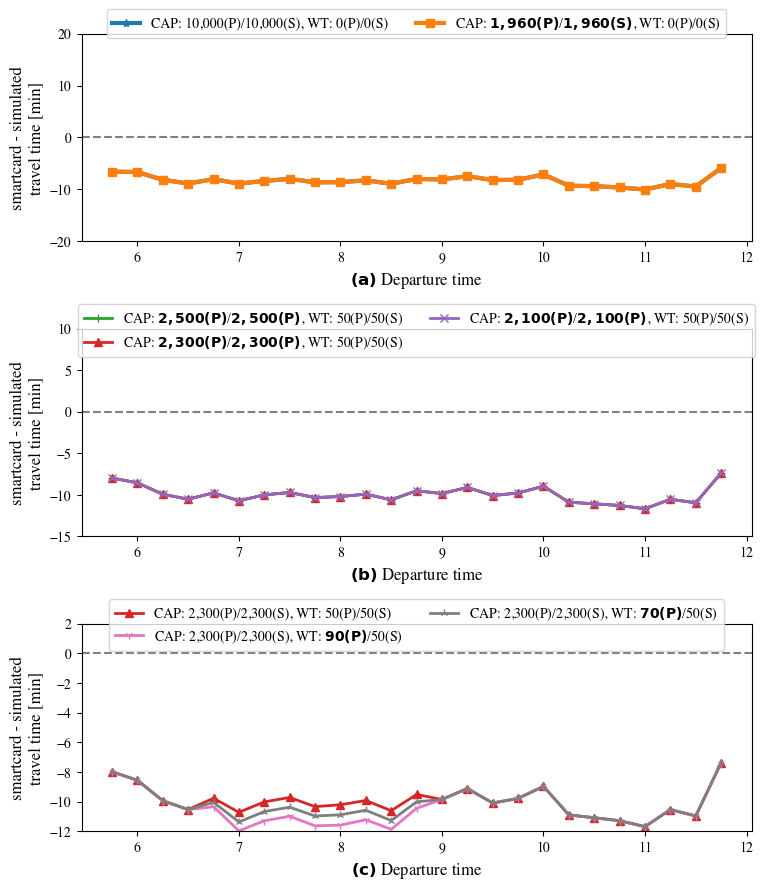

In [107]:
# fig, ax = plt.subplots(3, 1, figsize=(8, 9))
# ax[0].axhline(y=0, c='gray', ls='--')
# ax[1].axhline(y=0, c='gray', ls='--')
# ax[2].axhline(y=0, c='gray', ls='--')

# validation_dict_1 = {
#     'line_2_weekday_validation_cap10000_wt0-0': ('C0', '-*', 'CAP: 10,000(P)/10,000(S), WT: 0(P)/0(S)'),
#     'line_2_weekday_validation_cap1960_wt0-0': ('C1', '-s', r'CAP: $\bf{1,960(P)}$/$\bf{1,960(S)}$, WT: 0(P)/0(S)')
# }

# validation_dict_2 = {
#     'line_2_weekday_validation_cap2100_wt50-50': ('C2', '-+', r'CAP: $\bf{2,500(P)}$/$\bf{2,500(P)}$, WT: 50(P)/50(S)'),
#     'line_2_weekday_validation_cap2300_wt50-50': ('C3', '-^', r'CAP: $\bf{2,300(P)}$/$\bf{2,300(P)}$, WT: 50(P)/50(S)'),
#     'line_2_weekday_validation_cap2500_wt50-50': ('C4', '-x', r'CAP: $\bf{2,100(P)}$/$\bf{2,100(P)}$, WT: 50(P)/50(S)'),
# }

# validation_dict_3 = {
#     'line_2_weekday_validation_cap2300_wt50-50': ('C3', '-^', r'CAP: 2,300(P)/2,300(S), WT: 50(P)/50(S)'),
#     'line_2_weekday_validation_cap2300_wt90-50': ('C6', '-1', r'CAP: 2,300(P)/2,300(S), WT: $\bf{90(P)}$/50(S)'),
#     'line_2_weekday_validation_cap2300_wt70-50': ('C7', '-2', r'CAP: 2,300(P)/2,300(S), WT: $\bf{70(P)}$/50(S)'),
# }

# def grp_statistics(g):
#     values = g['time_diff']
#     mean = np.mean(values)
#     median = np.median(values)
#     std = np.std(values)
#     rmse = np.sqrt(sum(values**2)/len(values))
#     size = len(values)
#     return pd.Series({'mean': mean, 'std': std, 'rmse': rmse, 'size': size})

# for scen_nm_spec, scen_style in validation_dict_1.items():
#     validation_set = validation_dict[scen_nm_spec]

#     validation_set['departure_category'] = validation_set['departure_time'] // 900 * 0.25    
#     validation_grp = validation_set.groupby('departure_category').apply(grp_statistics).reset_index()
#     validation_grp = validation_grp[(validation_grp['departure_category'] >= 5.5)]
    
#     ax[0].plot(validation_grp['departure_category'].values, 
#                validation_grp['mean'].values * 60, 
#                scen_style[1], c=scen_style[0], lw=3, label=scen_style[2])
    
#     ax[0].set_ylim([-20, 20])
#     ax[0].set_xlabel(r'$\bf{(a)}$ Departure time', fontsize=12)
#     ax[0].set_ylabel('smartcard - simulated\ntravel time [min]', fontsize=12)
#     ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)

# for scen_nm_spec, scen_style in validation_dict_2.items():
#     validation_set = validation_dict[scen_nm_spec]
#     validation_set['departure_category'] = validation_set['departure_time'] // 900 * 0.25
#     validation_grp = validation_set.groupby('departure_category').apply(grp_statistics).reset_index()
#     validation_grp = validation_grp[(validation_grp['departure_category'] >= 5.5)]
    
#     ax[1].plot(validation_grp['departure_category'].values, 
#                validation_grp['mean'].values * 60, 
#                scen_style[1], c=scen_style[0], lw=2, label=scen_style[2])
    
#     ax[1].set_ylim([-15, 10])
#     ax[1].set_xlabel(r'$\bf{(b)}$ Departure time', fontsize=12)
#     ax[1].set_ylabel('smartcard - simulated\ntravel time [min]', fontsize=12)
#     ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)

# for scen_nm_spec, scen_style in validation_dict_3.items():
#     validation_set = validation_dict[scen_nm_spec]
#     validation_set['departure_category'] = validation_set['departure_time'] // 900 * 0.25    
#     validation_grp = validation_set.groupby('departure_category').agg(
#         {'time_diff': [np.mean, np.std, 'count']}).reset_index()
#     validation_grp = validation_grp[(validation_grp['departure_category'] >= 5.5)]

#     ax[2].plot(validation_grp['departure_category'].values, 
#                validation_grp['time_diff']['mean'].values * 60, 
#                scen_style[1], c=scen_style[0], lw=2, label=scen_style[2])

#     ax[2].set_ylim([-12, 2])
#     ax[2].set_xlabel(r'$\bf{(c)}$ Departure time', fontsize=12)
#     ax[2].set_ylabel('smartcard - simulated\ntravel time [min]', fontsize=12)
#     ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)

# plt.tight_layout()
# # plt.savefig('../uregina/figs/line_6_tune_cap_tt.png', dpi=300)


In [95]:
# validation_set.shape

(94323, 23)

### Backup: boarding status

#### Extracting and Analyzing Schedule Data for Specific Platforms
This code reads and processes schedule data to focus on a particular time window and merges it with platform information. It allows for detailed examination of train schedules at specific platforms or locations.

In [96]:
nodes = pd.read_csv('{}/ttcl2_nodes.csv'.format(out_path))
platforms = nodes[nodes['type'] == 'platform']
display(platforms.head(2))  # Display the first two rows of platform data for a quick check

schedule = pd.read_csv('{}/ttcl2_schedule.csv'.format(out_path))
schedule = schedule[(schedule['time'] >= 3600*6) & (schedule['time'] <= 3600*11)]  # Filter schedule between 6 AM and 11 AM

# Merge schedule data with platform information
schedule = pd.merge(schedule, platforms[['route_stop_id', 'node_id']],
                    how='inner', left_on='location', right_on='route_stop_id')

# Display details for a specific trip_id
display(schedule[schedule['trip_id'] == 47632745].sort_values(by='time').head(2))  # Example: Display the first two entries for trip_id 47632745

# Display details for a specific location
display(schedule[schedule['location'] == 'upward-Broadview'].head(2))  # Example: Display the first two entries for the Broadview location


,route_stop_id,stop_lon,stop_lat,stop_id,type,node_id,geometry
0,upward-Castle Frank,-79.368088,43.674049,Castle Frank,platform,0,POINT (-79.368088 43.674049)
1,upward-Broadview,-79.358088,43.677049,Broadview,platform,1,POINT (-79.358088 43.677049)


,trip_id,time,next_time,status,location,capacity,location_id,route_stop_id,node_id
35,47632745,33497.0,33527.0,stop,upward-Castle Frank,1960,0.0,upward-Castle Frank,0
122,47632745,33604.0,33634.0,stop,upward-Broadview,1960,1.0,upward-Broadview,1


,trip_id,time,next_time,status,location,capacity,location_id,route_stop_id,node_id
87,47632552,26964.0,26994.0,stop,upward-Broadview,1960,1.0,upward-Broadview,1
88,47632553,26632.0,26662.0,stop,upward-Broadview,1960,1.0,upward-Broadview,1


#### Aggregating and Tracking Traveler Status Changes

In [106]:
all_status_change = []
for time in range(3600*6, 3600*12):  # Loop through the time range from 6 AM to 12 PM
    try:
        # Attempt to read the status change file for the given time
        status_change = pd.read_csv('{}/traveler_outputs/status_change_{}_{}.csv'.format(out_path, output_scen_nm, time))
    except FileNotFoundError:
        # If the file does not exist, continue to the next iteration
        continue
    all_status_change.append(status_change)  # Append the status change data to the list

# Concatenate all the status change data into a single DataFrame
all_status_change_df = pd.concat(all_status_change)

# Create a new column 'previous_association' to track the previous association for each traveler
all_status_change_df['previous_association'] = all_status_change_df.groupby('traveler_id')['association'].shift(1)

#### Tracking Travelers Boarding at Broadview Station
This code snippet identifies and tracks travelers who boarded at the Broadview station. It assigns unique traveler IDs, filters for those who boarded at the specified platform, and verifies their entry stations.

In [111]:
display(all_status_change_df.iloc[10100:10110])

,traveler_id,traveler_status,update_time,association,previous_association
123,23274,2,24040,0,14.0
124,23376,2,24040,0,14.0
125,23402,2,24040,0,14.0
126,23556,2,24040,0,14.0
127,23800,2,24040,0,14.0
128,24092,2,24040,0,14.0
129,24134,2,24040,0,14.0
130,24224,2,24040,0,14.0
131,24714,2,24040,0,14.0
132,24834,2,24040,0,14.0


In [113]:
# Load the travelers data and assign a unique traveler ID to each row
travelers_df = pd.read_csv('{}/od_magenta_line_14_2023-08-20.csv'.format(in_path))
travelers_df.insert(loc=0, column='traveler_id', value=0)
travelers_df['traveler_id'] = np.arange(travelers_df.shape[0])
# Display the details of the 5th traveler
display(travelers_df.iloc[4:5])

# Identifying all travelers who boarded at the specified platform (Broadview)
platform_id, platform_nm = 14, 'Botanical Garden'
board_at_platform = all_status_change_df[
    (all_status_change_df['traveler_status'] == 2) &  # Traveler status 1 indicates boarding
    (all_status_change_df['previous_association'] == platform_id)  # Previous association should match the platform ID
].copy()
# Display the first entry of the boarding travelers
display(board_at_platform.head(1))

# Assign the service ID based on the association column
board_at_platform['service_id'] = board_at_platform['association']
# Sort the boarding travelers by the time they updated their status
board_at_platform = board_at_platform.sort_values(by='update_time')

# Verification: Check which stations these travelers entered from
unique_enter_stations = travelers_df.loc[
    travelers_df['traveler_id'].isin(board_at_platform['traveler_id']), 'enter_station'
].unique()

# Display the unique entry stations for these travelers
display(unique_enter_stations)

# Optionally save the results to a CSV file
# board_at_platform[['service_id', 'traveler_id', 'update_time']].to_csv(
#     'analysis_outputs/boarding_status_{}.csv'.format(platform_nm), index=False)


,traveler_id,date,hour,entry_time,deal_time,enter_station,exit_station,travel_time,exit_type,departure_time,route_id,stop_sequence
4,4,08-20-2023,18,18:05:39,18:14:27,Botanical Garden,Okhla Bird Sanctuary,9,0,65667,upward,0


,traveler_id,traveler_status,update_time,association,previous_association
24,182,2,22100,0,14.0


array(['Botanical Garden'], dtype=object)

In [115]:
### Display the data for a specific traveler (for debugging or analysis purposes)
# display(all_status_change_df[all_status_change_df['traveler_id']==18])

### Identify all travelers boarding at a specific platform
platform_id = 14  # Jamia Millia Islamia station
board_at_platform = all_status_change_df[
    (all_status_change_df['traveler_status'] == 2) &  # Traveler status 1 indicates boarding
    (all_status_change_df['previous_association'] == platform_id)  # Check for previous association with the platform
].copy()
display(board_at_platform.head(1))  # Display the first boarding traveler entry

### Optional: Visualization of the number of boarding travelers over time
# fig, ax = plt.subplots(figsize=(8, 4))
# major_ticks = np.arange(6, 12, 1)
# minor_ticks = np.arange(6, 12, 1/12)
# ax.hist(board_at_platform['update_time'] / 3600, bins=minor_ticks, histtype=u'step')
# ax.set_xticks(major_ticks)
# ax.set_xticks(minor_ticks, minor=True)
# ax.grid(which='minor', alpha=0.2)
# ax.grid(which='major', alpha=0.5)
# ax.set_xlabel('Time (Hours)')
# ax.set_ylabel('Number of Boarding Travelers')
# plt.title('# Boarding Passengers at Platform Broadview')

,traveler_id,traveler_status,update_time,association,previous_association
24,182,2,22100,0,14.0


In [226]:
# # count = schedule['location'].value_counts()
# # print(count)

# count = all_status_change_df['previous_association'].value_counts()
# print(count)

# count = all_status_change_df['traveler_status'].value_counts()
# print(count)

# display(all_status_change_df)
# all_status_change_df.to_csv('hello.csv')

previous_association
2.0           3552
10.0          3545
8.0           3528
14.0          3519
5.0           3494
              ... 
47632791.0      10
47632696.0      10
47632774.0       9
47632801.0       7
47632775.0       2
Name: count, Length: 180, dtype: int64
traveler_status
1    103023
2     53527
3     53277
4     49113
Name: count, dtype: int64


,traveler_id,traveler_status,update_time,association,previous_association
0,88256,1,21320,41,NaN
1,91929,1,21320,41,NaN
2,122137,1,21320,37,NaN
3,50476,4,21320,3,NaN
4,16772,3,21320,47632794,NaN
...,...,...,...,...,...
3169,144120,1,42900,15,47632700.0
3170,146026,1,42900,21,47632702.0
3171,148079,1,42900,21,47632702.0
3172,148130,1,42900,21,47632702.0


### Visualizing Train Schedule and Boarding Counts at Broadview Station
This code snippet processes and visualizes the relationship between train schedules and the number of passengers boarding at the Broadview station

Watching the passengers board is like waiting for popcorn to pop—slow at first, then suddenly everyone’s in a rush!

,trip_id,time,next_time,status,location,capacity,location_id
10,15351,22587.0,22607.0,stop,upward-Jamia Millia Islamia,1800,5.0


,traveler_id,traveler_status,update_time,association,previous_association
24,182,2,22100,0,14.0
25,302,2,22100,0,14.0
26,630,2,22100,0,14.0
27,681,2,22100,0,14.0
28,1211,2,22100,0,14.0


,association,boarding_counts,trip_id,next_time
0,0,16317,NaN,NaN


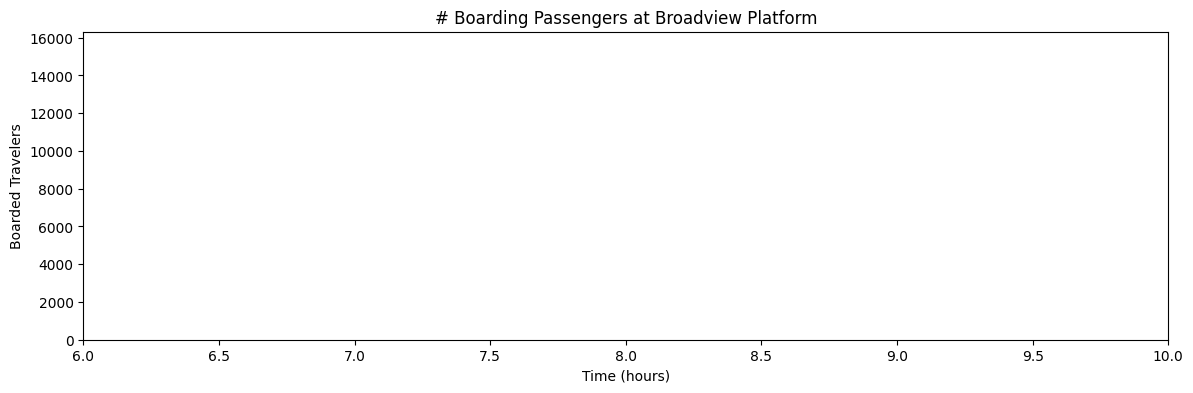

In [116]:
### Retrieve and display the train schedule for Broadview station
platform_schedule = schedule[schedule['location'] == 'upward-Jamia Millia Islamia'].copy()  # Filter schedule for Broadview station
platform_schedule = platform_schedule.sort_values(by='time')
display(platform_schedule.head(1))  # Display the first entry in the schedule

### Filter for travelers boarding at the specified platform
platform_id = 14  # Jamia Millia Islamia station ID
board_at_platform = all_status_change_df[
    (all_status_change_df['traveler_status'] == 2) &  # Traveler status 3 indicates boarding
    (all_status_change_df['previous_association'] == platform_id)  # Check for previous association with the platform
].copy()
display(board_at_platform.head())  # Display the first few rows of boarding data

### Group and merge boarding data with the train schedule
board_at_platform_grp = board_at_platform.groupby('association').size().to_frame('boarding_counts').reset_index()
board_at_platform_grp = board_at_platform_grp.merge(
    platform_schedule[['trip_id', 'next_time']],
    how='left', left_on='association', right_on='trip_id'
)
display(board_at_platform_grp.head(1))  # Display the first merged result

### Visualize the relationship between train schedules and boarding counts
fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(board_at_platform_grp['next_time'] / 3600, board_at_platform_grp['boarding_counts'])  # Plot boarding counts

# Determine maximum boarding count for scaling
max_boarding_count = max(board_at_platform_grp['boarding_counts'])

# Draw vertical lines for each train arrival, annotated with trip IDs
for row in board_at_platform_grp.itertuples():
    time_hours = getattr(row, 'next_time') / 3600
    boarding_count = getattr(row, 'boarding_counts')
    if time_hours < 10:  # Ensure the time is within the plot's x-axis limits
        ax.axvline(x=time_hours, ymin=0, ymax=boarding_count / max_boarding_count, color='red', linewidth=0.5)
        ax.text(time_hours, 0, getattr(row, 'trip_id'), rotation=90, fontsize=8, color='red', verticalalignment='bottom')

# Set plot limits and labels
ax.set_xlim([6, 10])
ax.set_ylim([0, max(board_at_platform_grp['boarding_counts']) ])  # Adjust the ylim to include some space above the highest point
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Boarded Travelers')
plt.title('# Boarding Passengers at Broadview Platform')

plt.show()

### Calculating Boarding Status for Travelers at a Specific Location
This code snippet calculates the boarding status for travelers at a specific location by iterating through the schedule and tracking each traveler's waiting time until they board a train.

In [105]:
# Initialize an empty list to store boarding status details
boarding_status = []
location_id = 2  # Location ID for Broadview station, can be adjusted as needed

# Iterate through each schedule stop at the specified location
for schedule_stop in schedule[schedule['location_id'] == location_id].itertuples():
    trip_id = getattr(schedule_stop, 'trip_id')  # Get the trip ID from the schedule
    # Identify travelers associated with the current trip ID
    boarding_travelers = all_status_change_df.loc[all_status_change_df['association'] == trip_id, 'traveler_id'].values
    print(trip_id, len(boarding_travelers))  # Print the trip ID and number of boarding travelers
    # Group the traveler status changes by traveler ID and calculate wait times
    for traveler_id, grp in all_status_change_df[all_status_change_df['traveler_id'].isin(boarding_travelers)].groupby('traveler_id'):
        try:
            # Retrieve the start and end times of the waiting period
            wait_start = grp[(grp['traveler_status'] == 2) & (grp['association'] == location_id)]['update_time'].iloc[0]
            wait_end = grp[(grp['traveler_status'] == 3) & (grp['association'] == trip_id)]['update_time'].iloc[0]
        except IndexError:
            continue  # Skip travelers who don't have a complete record
        # Append the calculated boarding status to the list
        boarding_status.append([traveler_id, wait_start, wait_end, trip_id, location_id])

# Convert the list into a DataFrame for easier analysis
boarding_status = pd.DataFrame(boarding_status, columns=['traveler_id', 'wait_start', 'wait_end', 'trip_id', 'node_id'])

47632552 1094
47632553 1152
47632556 469
47632558 1946
47632559 1292
47632560 1341
47632714 484
47632715 473
47632716 447
47632717 485
47632718 454
47632719 433
47632720 440
47632721 674
47632723 632
47632725 446
47632726 388
47632727 310
47632728 360
47632729 364
47632730 261
47632731 516
47632732 251
47632733 603
47632734 319
47632735 498
47632736 716
47632737 577
47632738 968
47632739 1387
47632740 767
47632741 1141
47632742 739
47632743 1150
47632744 1448
47632745 784
47632746 1163
47632747 681
47632748 1075
47632749 1678
47632750 943
47632751 1770
47632752 940
47632753 1175
47632754 1808
47632755 1030
47632756 1373
47632757 1514
47632758 1349
47632759 1349
47632760 1347
47632761 1384
47632762 1399
47632763 1474
47632764 1304
47632765 1475
47632766 1470
47632767 1494
47632768 1337
47632769 1386
47632770 1492
47632771 1410
47632772 1643
47632773 1430
47632778 1290
47632779 1427
47632780 1408
47632781 1403
47632782 1356
47632783 1346
47632784 1254
47632787 1348
47632788 1367
47632792

#### Calculating and Analyzing Waiting Times

Here, we calculate the waiting times for each traveler by subtracting the time they arrived at the platform from the time they boarded the train. 

In [79]:
# Calculate the waiting time for each traveler by subtracting the wait start time from the wait end time
boarding_status['waiting_time'] = boarding_status['wait_end'] - boarding_status['wait_start']

# Optional: Analyze the waiting time statistics for a specific trip at a specific platform
# boarding_status.loc[(boarding_status['trip_id'] == 171077) & (boarding_status['node_id'] == 0), 'waiting_time'].describe()

# Optional: Display the boarding status data for a specific trip to review waiting times
# boarding_status[boarding_status['trip_id'] == 171077]

#### Aggregating and Analyzing Boarding Data
This section of the code aggregates the boarding data by trip_id and node_id to calculate key statistics such as the number of passengers boarding, waiting times, and the interval between train departures. 

In [80]:
# Group the boarding status data by trip ID and node ID, and calculate aggregate statistics
tmp = boarding_status.groupby(['trip_id', 'node_id']).agg({
    'wait_end': 'mean',  # Average wait end time, indicating when passengers leave the platform
    'waiting_time': ['size', 'min', 'mean', 'max']  # Number of passengers and waiting time statistics
}).reset_index()

# Rename columns for clarity
tmp.columns = ['trip_id', 'node_id', 'leave_platform_at', 'boarding_passenger_counts', 'wait_minimum', 'wait_mean', 'wait_maximum']

# Sort the data by the time trains leave the platform
tmp = tmp.sort_values(by='leave_platform_at')

# Calculate the interval between train departures
tmp['train_interval'] = tmp['leave_platform_at'] - tmp['leave_platform_at'].shift(1)

# Format the leave platform time into hours, minutes, and seconds
tmp['leave_platform_at'] = tmp['leave_platform_at'].apply(lambda x: '{0:02.0f}:{1:02.0f}:{2:02.0f}'.format(x//3600, (x%3600)//60, x%60))

# Convert the mean waiting time to an integer
tmp['wait_mean'] = tmp['wait_mean'].astype(int)

# Save the aggregated results to a CSV file
tmp.to_csv('../transit_sim_outputs/waiting_statistics.csv', index=False)

### Viz 3: show traveler traces.

##### Viz 3.1 difference distribution

(227764, 15)


/var/folders/5l/_gztgvsd6kddjt9mfl54ldm00000gp/T/ipykernel_58726/3854621017.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  validation_set['deal_time'] = pd.to_datetime(validation_set['deal_time'].fillna('00:00:00'))


,traveler_id,origin_nid,destin_nid,departure_time,trip_distance,traveler_status,update_time,association,next_station_id,init_boarding_time,final_alighting_time,aboard_tmp,remain_cap,order,train_location_id,deal_time,time_diff,time_sim,time_card


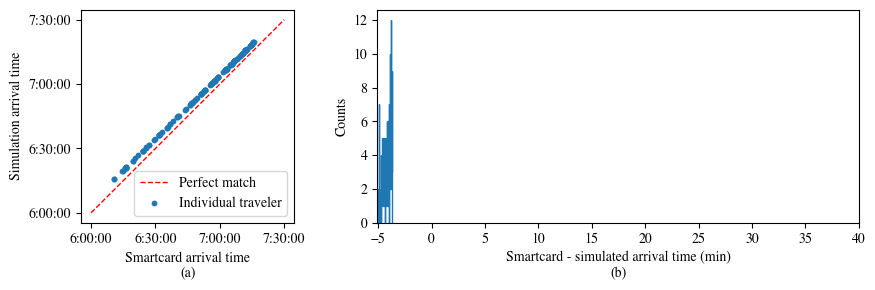

In [83]:
scen_nm_spec = 'bjl6'
traveler_output = pd.read_csv(
        # '{}/traveler_outputs/final_traveler_status_{}.csv'.format(out_path, scen_nm_spec))
        '{}/traveler_outputs/final_traveler_status_line_2_weekday_1960_wt90-90.csv'.format(out_path))
print(traveler_output.shape)

validation_set = traveler_output.merge(od_sample[['traveler_id', 'deal_time']], how='right', on='traveler_id')
validation_set['deal_time'] = pd.to_datetime(validation_set['deal_time'].fillna('00:00:00'))
validation_set['deal_time'] = (validation_set['deal_time']-validation_set['deal_time'].dt.normalize()
                               ).dt.total_seconds().astype(int)

#Changes Here
validation_set['update_time'] = reg.predict(np.array(validation_set['deal_time']).reshape(-1, 1))
# display(validation_set[validation_set['time_diff']<-0.1].head())
validation_set['time_diff'] = - validation_set['update_time']/3600 + validation_set['deal_time']/3600
#Till Here

validation_set['time_sim'] = validation_set['update_time']/3600 - validation_set['departure_time']/3600
validation_set['time_card'] = validation_set['deal_time']/3600 - validation_set['departure_time']/3600
validation_set['time_diff'] = - validation_set['update_time']/3600 + validation_set['deal_time']/3600



display(validation_set[validation_set['time_diff']<-0.1].head())
# validation_set['time_diff'].describe()

fig = plt.figure(figsize=(9, 3))
gs = GridSpec(1, 2, width_ratios=[1, 2])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax1.plot([3600*6, 3600*7.5], [3600*6, 3600*7.5], ls='--', lw=1, c='r', label='Perfect match')
ax1.scatter(validation_set['deal_time'], validation_set['update_time'], s=10, label='Individual traveler')
x_ticks = np.arange(3600*6, 3600*7.51, 1800)
# Now use timedelta in the code where you set the x-tick labels
x_ticklabels = [str(timedelta(seconds=int(t))) for t in x_ticks]
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_ticklabels)
ax1.set_xlabel('Smartcard arrival time\n(a)', fontsize=10)
ax1.set_yticks(x_ticks)
ax1.set_yticklabels(x_ticklabels)
ax1.set_ylabel('Simulation arrival time', fontsize=10)
ax1.set_aspect('equal')

ax2.hist(validation_set['time_diff']*60, histtype=u'step', bins=45)
x_ticks = np.arange(-5, 45, 5)
# Now use timedelta in the code where you set the x-tick labels
x_ticklabels = [str(timedelta(seconds=int(t))) for t in x_ticks]
ax2.set_xticks(x_ticks)
ax2.set_xlabel('Smartcard - simulated arrival time (min)\n(b)', fontsize=10)
ax2.set_ylabel('Counts', fontsize=10)

ax1.legend()
plt.tight_layout()
# plt.savefig('../uregina/figs/0600-0630_verification.png', dpi=200)

#### Conducting Statistical Tests on Time Differences

In this section, we perform statistical tests to evaluate whether the differences between simulated and actual travel times are statistically significant. We calculate the mean time difference and use t-tests to determine if these differences deviate significantly from zero, indicating potential biases in the simulation model.


In [84]:
# Calculate and print the mean time difference (in minutes) between the simulated and actual arrival times
print(np.mean(validation_set['time_diff']) * 60)

# Optionally, conduct a one-sample t-test to check if the mean time difference is significantly different from zero
# scipy.stats.ttest_1samp(validation_set['time_diff'], 0)

# Optionally, conduct a t-test on a subset of data where the absolute time difference is less than 0.2 hours (12 minutes)
# scipy.stats.ttest_1samp(validation_set.loc[np.abs(validation_set['time_diff']) < 0.2, 'time_diff'], 0)

-4.167068927499052


##### Viz 3.1 Validation

In [64]:
# Calculate and print the mean time difference (in minutes) for travelers who departed in the 6:15 AM to 6:30 AM window
print(np.mean(validation_set.loc[validation_set['departure_category'] == 6.25, 'time_diff']) * 60)

-9.934641324340895

### Visualizing Traveler Count
This block of code groups the validation data by departure time category and entrance station, calculating key statistics like the mean and standard deviation of time differences. It then plots the count of observations for each station over time.

Ever wondered which station is the most popular at dawn?

In [117]:
# Group the validation data by departure category and entrance station, then calculate mean, std, and count for time_diff
validation_grp = validation_set.groupby(['departure_category', 'enter_station']).agg(
    {'time_diff': [np.mean, np.std, 'count']}
).reset_index()

# Filter the data to include only departures from 5:30 AM onwards
validation_grp = validation_grp[(validation_grp['departure_category'] >= 5.5)]

# Plot the count of time_diff observations for each entrance station over time
for nm, grp in validation_grp.groupby('enter_station'):
    plt.plot(grp['departure_category'].values, 
             grp['time_diff']['count'].values, 
             lw=2, label=nm)  # Line width set to 2 for better visibility

# Add grid lines, labels, and legend to the plot
plt.grid()
plt.xlabel('Hour')  # X-axis label indicating the hour of the day
plt.ylabel('Entrance')  # Y-axis label indicating the count of entrances
plt.legend(loc=[1.1, 0.2])  # Legend placed to the right of the plot


NameError: name 'validation_set' is not defined

In [109]:
# Filter the validation data for travelers who departed between 6:15 AM and 6:30 AM
tmp = validation_set.loc[validation_set['departure_category'] == 6.25, ['traveler_id', 'time_sim', 'time_card', 'time_diff']]

# Optionally, plot a histogram of the time differences for this departure window
# plt.hist(tmp['time_diff'], bins=20, histtype=u'step')

# Optionally, create a scatter plot comparing simulated vs. actual (smartcard) travel times
# plt.scatter(tmp['time_sim'], tmp['time_card'])

# Optionally, identify travelers with significant time differences (e.g., greater than 6 minutes)
# tmp[tmp['time_diff'] > 0.1]

# Optionally, inspect the detailed validation data for a specific traveler by ID
# validation_set[validation_set['traveler_id'] == 89328]

# Optionally, group the validation data by traveler status to see how many are in each status category
# validation_set.groupby('traveler_status').size()

# Display the departure times for the first 100 travelers in the validation set
validation_set['departure_time'].iloc[0:100]

0      21893
2      41656
6      29477
7      32262
8      29088
       ...  
232    25842
234    41157
236    29539
237    34172
238    30261
Name: departure_time, Length: 100, dtype: int64

In [88]:
# ### train schedule between two stations
# schedule = pd.read_csv('../uregina/outputs/changping_schedule.csv')
# schedule['hour'] = schedule['time']/3600
# schedule = schedule[(schedule['hour']>=7) & (schedule['hour']<=11)]

# travel_time = []
# for trip_id, grp in schedule.groupby('trip_id'):
#     shahe_time = grp.loc[(grp['location']=='downward-shahe'), 'next_time']
#     if shahe_time.shape[0]==0:
#         continue
#     shahe_time = shahe_time.iloc[0]/3600
    
#     xierqi_time = grp.loc[(grp['location']=='downward-xierqi'), 'time']
#     if xierqi_time.shape[0]==0:
#         continue
#     xierqi_time = xierqi_time.iloc[0]/3600
    
#     travel_time.append([trip_id, round(shahe_time, 1), round(xierqi_time, 1), round((xierqi_time-shahe_time)*60, 2)])
    
# travel_time_df = pd.DataFrame(travel_time, columns=['trip_id', 'shahe_hour', 'xierqi_hour', 'travel_time'])
# travel_time_df = travel_time_df.sort_values(by='shahe_hour', ascending=True)
# display(travel_time_df)

##### Viz 3.2 Travel time distribution

#### Average waiting time

In [90]:
for t in range(t_start, 3600*10+1, 20):
    try:
        traveler_boarding = pd.read_csv(
            '../uregina/outputs/traveler_outputs/boarding_traveler_outputs_{}_{}.csv'.format(scen_nm, t))
    except FileNotFoundError:
        continue
    print(np.round(t/3600, 2), traveler_boarding.shape[0], np.mean(traveler_boarding['waiting_time'])/60)
    # display(traveler_boarding.head())
    # break